# Practica: Redes convolucionales

In [1]:
#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact, interact_manual, interactive, fixed

In [2]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

# Cifar 10
Es un conjunto de datos que tiene 60,000 imagenes de 32x32 a color de 10 clases distintas (cada clase con 6,000 elementos).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Podemos descargar CIFAR-10 con el modulo de torchvision.

In [3]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Para resolver el problema de clasificación de las imágenes de CIFAR-10 usaremos una red neuronal 
cuya arquitectura sea la siguiente:

* Una capa convolucional de entrada con un filtro de (5,5) y 64 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Otra capa convolucional con un filtro de (5,5) y 32 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
* Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
* Finalmente,una capa de salida con 10 neuronas



In [4]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET, self).__init__()
        #Definimos las capas que necesitamos para esta red 
        self.conv1=nn.Conv2d(3,64,kernel_size=(5,5))#,stride=5)
        self.pool=nn.MaxPool2d(kernel_size=(3,3))#,stride=3)
        self.norm1=nn.BatchNorm2d(64)
        self.norm2=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(64,32,kernel_size=(5,5))#,stride=5)
        self.fc1=nn.Linear(32,384)
        self.fc2=nn.Linear(384,192)
        self.fc3=nn.Linear(192,10)

    def forward(self, x,Norm=0):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        #Definimos el orden  en que se ejecutaran en estas capas
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        #Esta condicional es para normalizar los datos en caso de que se pida
        if Norm==1:
            x=self.norm1(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        if Norm==1:
            x=self.norm2(x)
        x=torch.flatten(x, 1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return(x)
    def train(self,epochs,data_loader,norm,criterion,optimizer,cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        E=[]
        #Definimos diferentes optimizadores que podemos usar
        if optimizer==0:
            algoritmo=optim.SGD(self.parameters(), lr=0.01)
        if optimizer==1:
            algoritmo=optim.Adam(self.parameters(), lr=0.01)
        if optimizer==2:
            algoritmo=optim.Adagrad(self.parameters(), lr=0.01)
        #Definimos diferentes criterios que podemos usar    
        if criterion==0:
            criterio=nn.CrossEntropyLoss()
        if criterion==1:
            criterio=nn.CTCLoss()
        if criterion==2:
            criterio=nn.GaussianNLLLoss()
        #Las veces que vamos a entrenar la red    
        for ciclos in range(epochs):
            #error_acum nos ayudara a ir sumando el error en cada ciclo
            error_acum=0.0
            for i,data in enumerate(data_loader,0):
                #obtenemos los datos entrada y las etiquetas de cada lote
                entradas,etiquetas= data
                #Definimos el entrenamiento
                algoritmo.zero_grad()
                salidas=self.forward(entradas,norm)   
                error=criterio(salidas,etiquetas) 
                error.backward()
                algoritmo.step()
                error_acum+=error.item()
                #La siguiente condicional es para reiniciar el valor de error_acum en cada lote 
                if i % 2000 == 1999:
                    #Nos ayuda a guardar los errores en cada ciclo para despues graficarlos
                    E.append(error_acum/2000)
                    error_acum = 0.0   
        self.errores=E
        #Graficamos
        x = np.arange(len(self.errores))
        plt.title("Error")
        plt.xlabel("ciclo")
        plt.scatter(x, self.errores)

In [5]:
#Cargamos los datos de la red ya entrenada
PATH = './CIFAR_50.pth'
#RedCIFAR=CIFAR_NET()
#RedCIFAR.load_state_dict(torch.load(PATH))

Entrenamos la red por 100 ciclos con optimizador SGD y entropia cruzada

Los datos de entrada no estan normalizados.

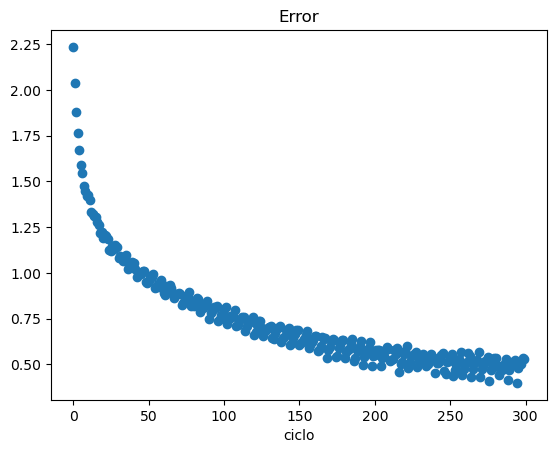

In [6]:
RedCIFAR=CIFAR_NET()
#Define el criterio que usaras para evaluar a la red y un optimizador.
#Y define el preprosesamiento necesario en caso de requerir usar cuda.

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(50,trainloader,0,0,0,cuda=False) #puedes agregar cuda=True si tienes GPU disponible

In [7]:
#Gurdamos los datos de nuestra red entrenada
torch.save(RedCIFAR.state_dict(), PATH)

In [8]:
RedCIFAR=CIFAR_NET()
RedCIFAR.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 86.5180%
Precision en conjunto de validacion: 61.7600%


Gracias a la funcion anterior podemos ver que nuestra red tiene una buena precision en el conjunto de entrenamiento pero en el de validación no tanto, tal vez si entrenamos un poco más la red la precision mejorara.

## Ejercicios:
* Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve. Muestra la imagen con la que se está alimentando a la red.
* Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles. Para ello en lugar de tener en cuenta únicamente los valores de verdaderos positivos, verdaderos negativos, etc, se usarán los 10 elementos, por lo que debemos tener en cuenta cuantos de cada categoria fueron clasificados incorrectamente, y en cual fue.
* Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.

## Observación 

In [10]:
#Definimos la funcion que nos ayudara a graficar las imagenes
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [11]:
#Volvemos nuestros datos in iterador para poder movernos en ellos
dataiter=iter(trainloader)
#La siguiente funcion nos ayuda a graficar las imagenes con la que se esta alimentando la red,  ver sus etiquetas y las predicciones que hace la red 
@interact(index = (1, len(dataiter) - 1))
def muestraimg(index):
    dataiter=iter(trainloader)
    for i in range(index):
        imagen,etiqueta= next(dataiter)
    imshow(torchvision.utils.make_grid(imagen))
    print("Etiquetas:" ,' '.join(f'{classes[etiqueta[j]]:5s}' for j in range(4)))
    salidas=RedCIFAR(imagen)
    _, prediccion=torch.max(salidas,1)
    print('Predicciones: ', ' '.join(f'{classes[prediccion[j]]:5s}'for j in range(4)))

interactive(children=(IntSlider(value=6250, description='index', max=12499, min=1), Output()), _dom_classes=('…

Como podemos ver la red predice a la perfeccion la imagen 

## Matriz de Confusion

In [12]:
#Definimos nuestra matriz de confusion
def matrizdeconfusion(red,data_loader):
    #Obtenemos la matriz de confusion de cada etiqueta
    for j in range(10):
        dataiter=iter(data_loader)
        predicciones=[]
        etiquetas=[]
        for i in range(len(dataiter)):
            imagen,etiqueta=next(dataiter)
            salidas=red(imagen)
            _, prediccion=torch.max(salidas,1)
            #Pasamos por cada elemento de dataiter y agregamos un 1 a etiquetas si es la etiqueta que necesitamos y 0 en otro caso, de mismo modo para predicciones 
            for k in range(4):
                if etiqueta[k]==j:
                    etiquetas.append(1)
                else:
                    etiquetas.append(0)
                if prediccion[k]==j:
                    predicciones.append(1)
                else:
                    predicciones.append(0)
        #Obtenemos nuestra matriz de forma tradicional            
        prediccion =np.array(predicciones).astype(bool)
        etiquetas = np.array(etiquetas).astype(bool)
    
        matriz = np.zeros((2,2))
        TP = np.sum(np.logical_and(prediccion, etiquetas))
        matriz[0][0] = TP
    
        TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
        matriz[1][1] = np.sum(TN)
    
        FP = np.logical_and(np.logical_not(etiquetas), prediccion)
        matriz[1][0] = np.sum(FP)
    
        FN = np.logical_and(etiquetas, np.logical_not(prediccion))
        matriz[0][1] = np.sum(FN)
        print("Matriz",classes[j])
        print( matriz)
                  

In [13]:
matrizdeconfusion(RedCIFAR,trainloader)

Matriz plane
[[ 4268.   732.]
 [  474. 44526.]]
Matriz car
[[ 4544.   456.]
 [  205. 44795.]]
Matriz bird
[[ 3914.  1086.]
 [  493. 44507.]]
Matriz cat
[[ 3786.  1214.]
 [ 1117. 43883.]]
Matriz deer
[[ 4123.   877.]
 [  706. 44294.]]
Matriz dog
[[ 4257.   743.]
 [ 1294. 43706.]]
Matriz frog
[[ 4443.   557.]
 [  421. 44579.]]
Matriz horse
[[ 4600.   400.]
 [  666. 44334.]]
Matriz ship
[[ 4658.   342.]
 [  732. 44268.]]
Matriz truck
[[ 4666.   334.]
 [  633. 44367.]]


In [14]:
matrizdeconfusion(RedCIFAR,testloader)

Matriz plane
[[ 623.  377.]
 [ 318. 8682.]]
Matriz car
[[ 706.  294.]
 [ 197. 8803.]]
Matriz bird
[[ 483.  517.]
 [ 378. 8622.]]
Matriz cat
[[ 419.  581.]
 [ 560. 8440.]]
Matriz deer
[[ 509.  491.]
 [ 374. 8626.]]
Matriz dog
[[ 601.  399.]
 [ 610. 8390.]]
Matriz frog
[[ 676.  324.]
 [ 276. 8724.]]
Matriz horse
[[ 676.  324.]
 [ 357. 8643.]]
Matriz ship
[[ 754.  246.]
 [ 392. 8608.]]
Matriz truck
[[ 729.  271.]
 [ 362. 8638.]]


Gracias a las matrices podemos ver que los gatos es lo que menos reconoce la red y que los camiones es lo que mejor reconoce en el conjunto de entrenamiento y en el de validacion

## Datos Normalizados

Entrenamos la red por 100 ciclos con optimizador SGD y entropia cruzada

Los datos de entrada no estan normalizados.

Normalizamos los datos despúes de cada Maxpool

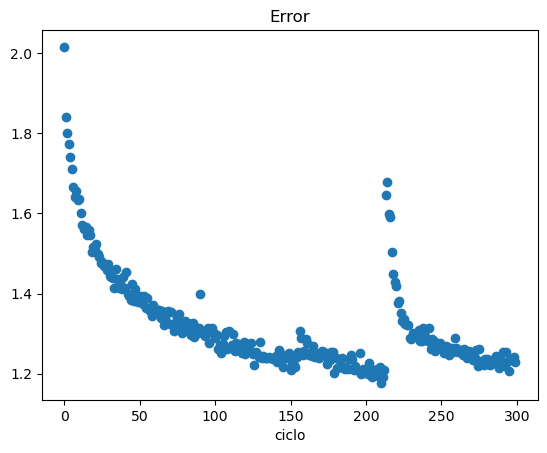

In [15]:
RedCIFAR_Norm=CIFAR_NET()
#RedCIFAR_Norm.load_state_dict(torch.load(PATH_N))
RedCIFAR_Norm.train(50,trainloader,1,0,0,cuda=False)

In [16]:
#Guardamos los datos 
PATH_N = './CIFAR_N_50.pth'
torch.save(RedCIFAR_Norm.state_dict(), PATH_N)

In [17]:
RedCIFAR_Norm=CIFAR_NET()
RedCIFAR_Norm.load_state_dict(torch.load(PATH_N))

<All keys matched successfully>

In [18]:
prec_train =calcularPrecisionGlobal(RedCIFAR_Norm,trainloader,4)
prec_val   =calcularPrecisionGlobal(RedCIFAR_Norm,testloader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 16.3640%
Precision en conjunto de validacion: 15.6200%


Como podemos ver por la grafica y por la precisión tenemos que esta red se entreno de peor manera que la anterior por lo que concluimos que la primer red sin normalizar es más eficiente.

Referencias:
* Krizhevsky , Nair , Hinton. CIFAR-10. https://www.cs.toronto.edu/~kriz/cifar.html
* Pytorch, TORCH.NN, https://pytorch.org/docs/stable/nn.html
* Goodfellow-et-al. (2016). Deep Learning. MIT Press. https://www.deeplearningbook.org/contents/convnets.html

In [21]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()